# Dipole
This example reproduces the topology constraint.

In [1]:
import os


In [2]:
from quadcoil import quadcoil

import desc
from desc.objectives import QuadcoilProxy,  ObjectiveFunction

from simsopt.util import MpiPartition, log
from simsopt.mhd import Vmec, Boozer, Quasisymmetry
from simsopt.objectives import LeastSquaresProblem
from simsopt.solve import least_squares_mpi_solve
from simsopt.field import CurrentPotentialFourier, CurrentPotentialSolve

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import block_until_ready, devices, config
import time
devices()

[CudaDevice(id=0), CudaDevice(id=1)]

## Loading files

In [3]:
# Loading equilibrium into DESC
# wout_file = 'wout_li383_low_res_reference' # 
wout_file = 'wout_LandremanPaul2021_QA_lowres' # "wout_muse++.nc"
desc_eq = desc.vmec.VMECIO.load(wout_file + '.nc')
config.update('jax_enable_x64', True)

# Problem settings

In [4]:
# Settings 
separation = desc_eq.compute(['a'])['a']
mpol = 12
ntor = 12
nfp = desc_eq.NFP
plasma_M_theta = 16
plasma_N_phi = 32

## Running REGCOIL to estimate a field error target
In a real study, this will be replaced with the engineering target

In [5]:
# We first create a dummy objective to extract its quadrature
# points, plasma surface and net poloidal current.
# This will allow us to sanity check the objectie's value
# against baseline QUADCOIL and REGCOIL.
objective_dummy = QuadcoilProxy(
    eq=desc_eq,
    quadcoil_args={
        'mpol': mpol,
        'ntor': ntor,
        'plasma_coil_distance':0.1,
    },
    metric_name='f_max_Phi2',
    metric_target=0.,
    metric_weight=1.,
    plasma_M_theta=plasma_M_theta,
    plasma_N_phi=plasma_N_phi,
    # target=None,
    # bounds=None,
    # weight=1,
    normalize=False,
    normalize_target=False,
    name="QUADCOIL Proxy",
    verbose=False,
    # Bnormal_plasma_chunk_size=None,
    # source_grid=None,
    # jac_chunk_size=None,
)
objective_dummy.build()
_, qp_dummy, _, _ = objective_dummy.compute_full(*objective_dummy.xs(desc_eq))
plasma_quadpoints_phi = np.array(objective_dummy.plasma_quadpoints_phi)
plasma_quadpoints_theta = np.array(objective_dummy.plasma_quadpoints_theta)
winding_quadpoints_phi = np.linspace(0, 1, len(plasma_quadpoints_phi) * nfp)
winding_quadpoints_theta = np.linspace(0, 1, len(plasma_quadpoints_theta))
plasma_surface = qp_dummy.plasma_surface
net_poloidal_current_amperes = qp_dummy.net_poloidal_current_amperes

Precomputing transforms


In [6]:
if not os.path.exists('regcoil_' + wout_file + '.npy'):
    # We scan the REGCOIL regularization factor and recover the 
    # dipole distribution Caoxiang's paper chose
    f_B_test_list = []
    phi_test_list = []
    f_K_test_list = []
    time_quadcoil_list = []
    time_regcoil_list = []
    phi_ans_list = []
    f_B_ans_list = []
    f_K_ans_list = []
    for i in 10**np.linspace(-20, -10, 20):
        # Run QUADCOIL first
        time1 = time.time()
        regcoili_out_dict, regcoili_qp, regcoili_phi_mn, status = quadcoil(
            nfp=plasma_surface.nfp,
            stellsym=plasma_surface.stellsym,
            mpol=mpol,
            ntor=ntor,
            plasma_dofs=plasma_surface.dofs,
            plasma_mpol=plasma_surface.mpol,
            plasma_ntor=plasma_surface.ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            plasma_quadpoints_phi=plasma_quadpoints_phi,
            plasma_quadpoints_theta=plasma_quadpoints_theta,
            winding_quadpoints_phi=winding_quadpoints_phi,
            winding_quadpoints_theta=winding_quadpoints_theta,
            plasma_coil_distance=-separation, # DESC surface normal points inward
            objective_name=('f_B', 'f_K'),
            objective_weight=np.array([1., i]),
            objective_unit=(1., 1.),
            metric_name=('f_B', 'f_K'),
        )
        # block_until_ready(regcoili_phi_mn)
        # block_until_ready(regcoili_out_dict)
        # block_until_ready(regcoili_qp)
    
        phi_test_list.append(regcoili_phi_mn)
        f_B_test_list.append(regcoili_out_dict['f_B']['value'])
        f_K_test_list.append(regcoili_out_dict['f_K']['value'])
        time2 = time.time()
        time_quadcoil_list.append(time2-time1)
        print('i =', i, '| time =', time2-time1)
    
        wsi = regcoili_qp.winding_surface.to_simsopt()
        psi = regcoili_qp.plasma_surface.to_simsopt()
        cpi = CurrentPotentialFourier(
            wsi, mpol=mpol, ntor=ntor,
            net_poloidal_current_amperes=net_poloidal_current_amperes,
            net_toroidal_current_amperes=0.,
            stellsym=True)
        cpsti = CurrentPotentialSolve(cpi, psi, 0)
        regcoili_phi_mn_ans, regcoili_f_B_ans, regcoili_f_K_ans = cpsti.solve_tikhonov(i)
        time2 = time.time()
        time_regcoil_list.append(time2-time1)
        phi_ans_list.append(regcoili_phi_mn_ans)
        f_B_ans_list.append(regcoili_f_B_ans)
        f_K_ans_list.append(regcoili_f_K_ans)
        
    print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
    print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')
    print('REGCOIL avg time:', np.average(time_regcoil_list), '(s)')
    print('REGCOIL max time:', np.max(time_regcoil_list), '(s)')
    time_regcoil_list = np.array(time_regcoil_list)
    phi_ans_list = np.array(phi_ans_list)
    f_B_ans_list = np.array(f_B_ans_list)
    f_K_ans_list = np.array(f_K_ans_list)
    time_quadcoil_list = np.array(time_quadcoil_list)
    phi_test_list = np.array(phi_test_list)
    f_B_test_list = np.array(f_B_test_list)
    f_K_test_list = np.array(f_K_test_list)
    jnp.save('regcoil_' + wout_file + '.npy',{
        'regcoili_qp': regcoili_qp,
        'time_regcoil_list': time_regcoil_list,
        'phi_ans_list': phi_ans_list,
        'f_B_ans_list': f_B_ans_list,
        'f_K_ans_list': f_K_ans_list,
        'time_quadcoil_list': time_quadcoil_list,
        'phi_test_list': phi_test_list,
        'f_B_test_list': f_B_test_list,
        'f_K_test_list': f_K_test_list,
    })
    # Is quadcoil really well-behaved than regcoil?
    print('Quadcoil seems to be more well-behaved than regcoil.')    
    from quadcoil.quantity import f_B
    print('quadcoil f_B', f_B(regcoili_qp, phi_test_list[0]))
    print('regcoil  f_B', f_B(regcoili_qp, phi_ans_list[0]))
    plt.plot(phi_test_list[0], label='regcoil')
    plt.plot(phi_ans_list[0], label='quadcoil', linestyle='dashed')
    plt.legend()
    plt.show()
else:
    dict = jnp.load('regcoil_' + wout_file + '.npy', allow_pickle=True).item()
    regcoili_qp = dict['regcoili_qp']
    time_regcoil_list = dict['time_regcoil_list']
    phi_ans_list = dict['phi_ans_list']
    f_B_ans_list = dict['f_B_ans_list']
    f_K_ans_list = dict['f_K_ans_list']
    time_quadcoil_list = dict['time_quadcoil_list']
    phi_test_list = dict['phi_test_list']
    f_B_test_list = dict['f_B_test_list']
    f_K_test_list = dict['f_K_test_list']

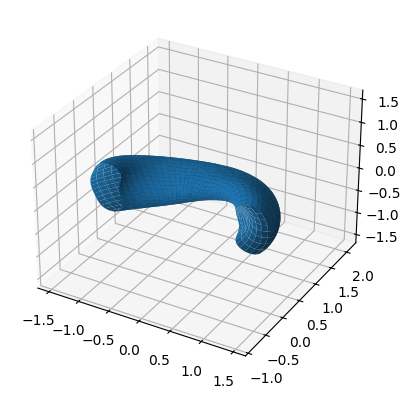

<Axes3D: >

In [7]:
regcoili_qp.eval_surface.to_simsopt().plot()

f_K at the inflection point: 6901532000000.0
f_B at the inflection point: 9.9165816e-05


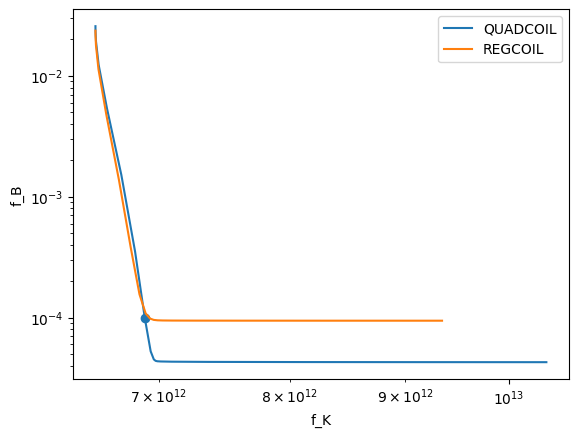

In [8]:
# inflection point
i_infl = 10 # np.argmin(f_K_test_list * f_B_test_list)
plt.plot(f_K_test_list, f_B_test_list, label='QUADCOIL')
plt.plot(f_K_ans_list, f_B_ans_list, label='REGCOIL')
plt.ylabel('f_B')
plt.xlabel('f_K')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.scatter(f_K_test_list[i_infl], f_B_test_list[i_infl])
print('f_K at the inflection point:', f_K_test_list[i_infl])
print('f_B at the inflection point:', f_B_test_list[i_infl])
f_B_target = f_B_test_list[i_infl]
phi_regcoil = phi_test_list[i_infl]

In [9]:
print('max phi', jnp.max(phi_ans_list[i_infl]))
print('mean abs phi', jnp.average(jnp.abs(phi_ans_list[i_infl])))

max phi 121572.33720419333
mean abs phi 1375.9468105108122


In [10]:
# Calculating normalization factors
from quadcoil.quantity import f_max_Phi2, f_B, f_max_Phi, Phi
# Auto-normalization will not work for dipole objectives,
# because they are zero when Phi is 0.
# Therefore, we choose instead to normalize
# using the Phi measured from the inflection point.
unit_Phi2 = f_max_Phi2(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi^2) =', unit_Phi2, 'At the inflection point.')
unit_Phi = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
print('Max(Phi) =', unit_Phi, 'At the inflection point.')
f_Phi_crtl = unit_Phi
quadcoil_kwargs = {
    'mpol': mpol,
    'ntor': ntor,
    'winding_quadpoints_phi': winding_quadpoints_phi,
    'winding_quadpoints_theta': winding_quadpoints_theta,
    'plasma_quadpoints_phi': plasma_quadpoints_phi,
    'plasma_quadpoints_theta': plasma_quadpoints_theta,
    'objective_name': 'f_max_Phi', # Minimizing peak dipole density
    'objective_unit': unit_Phi, # under an f_B constraint
    'constraint_name': ('f_B',),
    'constraint_type': ('<=',),
    'constraint_unit': (f_B_target,),
    'constraint_value': np.array([f_B_target,]),
    # 'verbose':1,
}

Max(Phi^2) = 99414410000.0 At the inflection point.
Max(Phi) = 315300.5 At the inflection point.


# Quasi-single-stage
Caoxiang's objective is:
```
prob = LeastSquaresProblem.from_tuples([(equil.volume, 0.012, 1e6),
                                        (equil.iota_axis, 0.18, 1e4),
                                        (equil.iota_edge, 0.2, 1e4),
                                        (qs.J, 0, 1e7),
                                        (reg.J, 0, 1)])
```
It's easier to do 2-term QS in DESC so we swap out that.

In [11]:
from desc.grid import LinearGrid
from desc.objectives import (
    ObjectiveFunction, 
    ForceBalance, FixPressure, FixCurrent, FixPsi,
    QuasisymmetryTwoTerm, RotationalTransform, 
    QuadcoilProxy, Volume, AspectRatio
)
from desc.optimize import Optimizer

In [12]:
# Building grids
qsgrid = LinearGrid(
    M=desc_eq.M_grid, N=desc_eq.N_grid, NFP=desc_eq.NFP, rho=np.array([0.1, 1.0]), sym=True
)

iotagridaxis = LinearGrid(
    M=desc_eq.M_grid, N=desc_eq.N_grid, NFP=desc_eq.NFP, rho=np.array([0.01]), sym=True
)

iotagridedge = LinearGrid(
    M=desc_eq.M_grid, N=desc_eq.N_grid, NFP=desc_eq.NFP, rho=np.array([1.0]), sym=True
)

In [13]:
A = plasma_surface.to_simsopt().aspect_ratio()
iota_axis = desc_eq.compute(['iota'], grid=iotagridaxis)['iota'][0]
iota_edge = desc_eq.compute(['iota'], grid=iotagridedge)['iota'][0]
vol = desc_eq.compute(['V'])['V']
obj = QuasisymmetryTwoTerm(desc_eq, helicity=(1,0))
obj.build()
normalized_qs_val = obj.compute(*obj.xs(desc_eq)) / obj.normalization

Precomputing transforms


In [14]:
quadcoil_kwargs_obj = quadcoil_kwargs.copy()
quadcoil_kwargs_obj['plasma_coil_distance'] = separation 
quadcoil_objective = QuadcoilProxy(
    eq=desc_eq,
    quadcoil_args=quadcoil_kwargs_obj,
    metric_name=('f_max_Phi',),
    metric_target=np.array([0.,]),
    metric_weight=np.array([1./f_Phi_crtl,]),
    plasma_M_theta=plasma_M_theta,
    plasma_N_phi=plasma_N_phi,
    normalize=False,
    normalize_target=False,
    name="QUADCOIL Proxy",
    verbose=0,
)
quadcoil_objective.build()

/home/lankef/code/DESC/desc/objectives/_quadcoil.py:166: UserWarning: Redundant arguments detected: {'plasma_quadpoints_theta', 'plasma_quadpoints_phi'}. These arguments are extracted from the equilibrium, or specified by other parameters. The provided values will be discarded.
  warnings.warn(


Precomputing transforms


In [15]:
import time
import jax

In [16]:
# Timing quadcoil
time1 = time.time()
test_f = quadcoil_objective.compute_unscaled(*quadcoil_objective.xs(desc_eq))
print('objective', jax.block_until_ready(test_f))
time2 = time.time()
print('time:', time2-time1)

objective [0.86490775]
time: 20.964396953582764


In [17]:
out_dict_obj, qp_obj, phi_mn_obj, status_obj = quadcoil_objective.compute_full(*quadcoil_objective.xs(desc_eq))

In [18]:
qp_obj.plasma_surface.to_simsopt().to_vtk('plasma_desc')
plasma_surface.to_simsopt().to_vtk('plasma_vmec')
qp_obj.eval_surface.to_simsopt().to_vtk('eval_desc')
regcoili_qp.eval_surface.to_simsopt().to_vtk('eval_vmec')

f_B from REGCOIL:       9.916495420852547e-05
f_B from QUADCOIL+DESC: 9.91893964512859e-05
Max dipole dens from REGCOIL:       315300.5
Max dipole dens from QUADCOIL+DESC: 272705.84146111226 13.509 % improvement


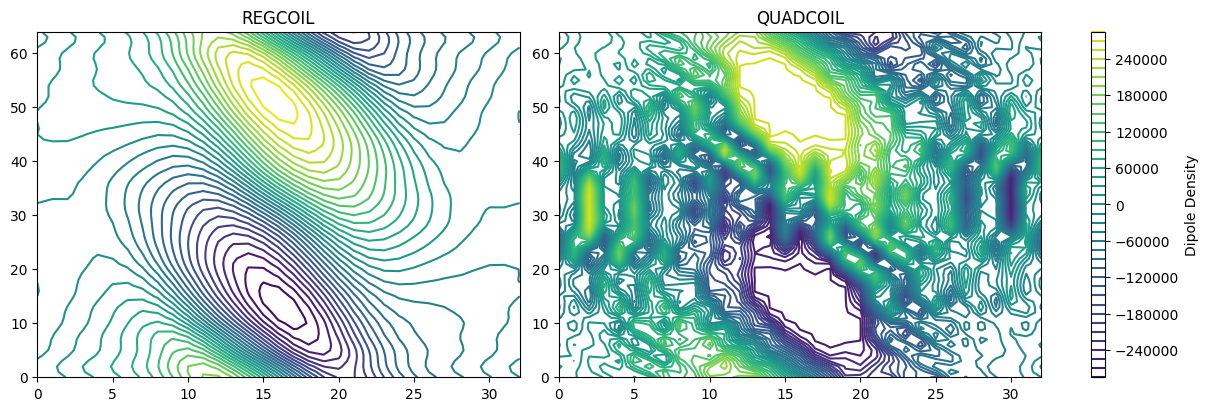

In [19]:
print('f_B from REGCOIL:      ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL+DESC:', f_B(qp_obj, phi_mn_obj))
f_Phi_crtl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
f_Phi_2 = f_max_Phi(qp_obj, phi_mn_obj)
print('Max dipole dens from REGCOIL:      ', f_Phi_crtl)
print('Max dipole dens from QUADCOIL+DESC:', f_Phi_2, round((f_Phi_crtl-f_Phi_2)/f_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(regcoili_qp, phi_test_list[i_infl])
phi_quadcoil2 = Phi(qp_obj, phi_mn_obj)
cmin = np.min([phi_regcoil, phi_quadcoil2])
cmax = np.max([phi_regcoil, phi_quadcoil2])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].contour(phi_regcoil, vmin=cmin, vmax=cmax, levels=40)
axes[0].set_title('REGCOIL')

# Plot for QUADCOIL
im1 = axes[1].contour(phi_quadcoil2, vmin=cmin, vmax=cmax, levels=40)
axes[1].set_title('QUADCOIL')

# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density")

plt.show()


In [20]:
out_dict_obj['f_max_Phi']['value']

Array(272705.84146111, dtype=float64)

In [21]:
constraints = (
    ForceBalance(eq=desc_eq),
    # FixPressure(eq=desc_eq),
    # FixCurrent(eq=desc_eq),
    FixPsi(eq=desc_eq),
)
qs_objective = QuasisymmetryTwoTerm(
    desc_eq, 
    helicity=(1,0), 
    target=normalized_qs_val, 
    normalize_target=False
)
objective = ObjectiveFunction((
    # ForceBalance(eq=desc_eq),
    Volume(eq=desc_eq, target=vol),
    AspectRatio(
        eq=desc_eq,
        target=A,
        weight=1,
    ),
    qs_objective,
    # Axis rotational transform
    RotationalTransform(
        eq=desc_eq,
        target=iota_axis,
        weight=1,
        grid=iotagridaxis,
    ),
    # Edge rotational transform
    RotationalTransform(
        eq=desc_eq,
        target=iota_edge,
        weight=1,
        grid=iotagridedge,
    ),
    quadcoil_objective
))


In [ ]:
optimizer = Optimizer('fmin-auglag-bfgs')
if True: # not os.path.exists('dipole_' + wout_file + '_eq.h5'):
    eqb, history = desc_eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        # each iteration of the augmented Lagrangian optimizer is cheaper than a step of a
        # proximal optimizer, but it generally requires more iterations to converge
        maxiter=100, # For now fails at iter #2
        copy=True,
        verbose=3,
        options={},
    )
    eqb.save('dipole_' + wout_file + '_eq.h5')
else:
    eqb = desc.io.load('dipole_' + wout_file + '_eq.h5')

Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 26.4 ms
Timer: Objective build = 2.21 ms
Timer: LinearConstraintProjection build = 132 ms
Timer: LinearConstraintProjection build = 90.1 ms
Number of parameters: 1066
Number of objectives: 500
Number of equality constraints: 4224
Number of inequality constraints: 0
Timer: Initializing the optimization = 272 ms

Starting optimization
Using method: fmin-auglag-bfgs
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality    Constr viol.   Penalty param  max(|mltplr|) 
       0              1          3.741e-01                                    3.171e+02      1.578e-02      1.000e+01      0.000e+00   
       1             12          3.739e-01      1.450e-04      9.537e-07      5.416e-07      1.574e-02      1.119e+01      7.922e-02   
  

In [23]:
out_dict_qss, qp_qss, dofs_mn_qss, status_qss = quadcoil_objective.compute_full(*quadcoil_objective.xs(eqb))

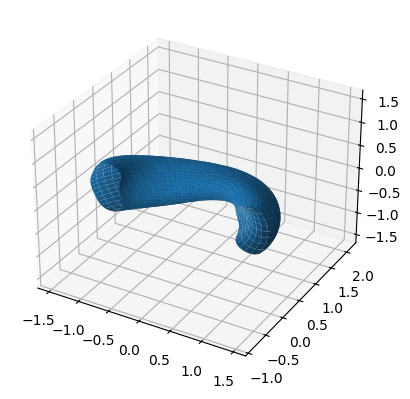

<Axes3D: >

In [24]:
qp_qss.eval_surface.to_simsopt().plot()

In [25]:
qp_qss.eval_surface.to_simsopt().to_vtk('after_desc')

f_B from REGCOIL, before:  9.916495420852547e-05
f_B from QUADCOIL, before: 9.91893964512859e-05
f_B from QUADCOIL, after:  9.918542704347841e-05
Max dipole dens from REGCOIL:       315300.5
Max dipole dens from QUADCOIL+DESC: 272705.84146111226 13.509 % improvement
Max dipole dens from QUADCOIL+DESC: 272719.54182197136 13.505 % improvement


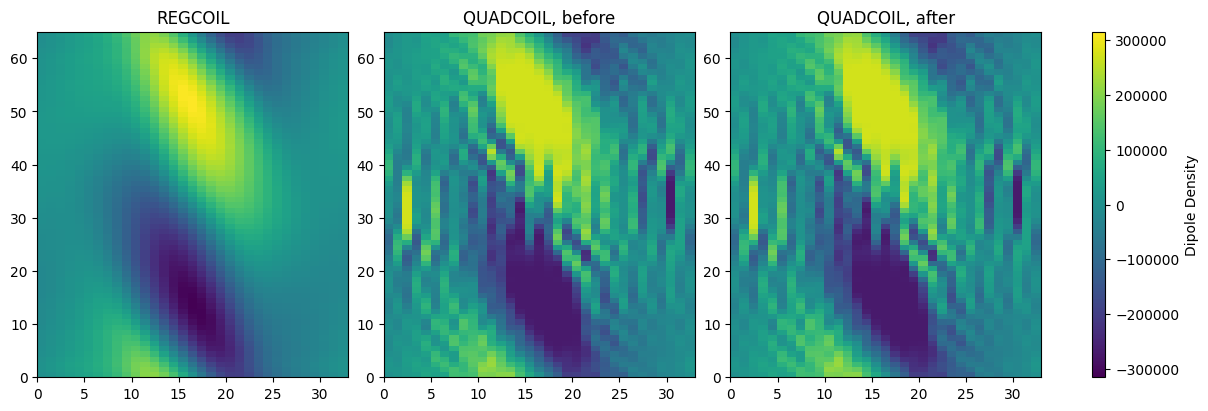

In [26]:
print('f_B from REGCOIL, before: ', f_B(regcoili_qp, phi_test_list[i_infl]))
print('f_B from QUADCOIL, before:', f_B(qp_obj, phi_mn_obj))
print('f_B from QUADCOIL, after: ', f_B(qp_qss, dofs_mn_qss))
f_Phi_crtl = f_max_Phi(regcoili_qp, phi_test_list[i_infl])
f_Phi_2 = f_max_Phi(qp_obj, phi_mn_obj)
f_Phi_3 = f_max_Phi(qp_qss, dofs_mn_qss)
print('Max dipole dens from REGCOIL:      ', f_Phi_crtl)
print('Max dipole dens from QUADCOIL+DESC:', f_Phi_2, round((f_Phi_crtl-f_Phi_2)/f_Phi_crtl*100, 3), '% improvement')
print('Max dipole dens from QUADCOIL+DESC:', f_Phi_3, round((f_Phi_crtl-f_Phi_3)/f_Phi_crtl*100, 3), '% improvement')

phi_regcoil = Phi(regcoili_qp, phi_test_list[i_infl])
phi_quadcoil = Phi(qp_obj, phi_mn_obj)
phi_quadcoil3 = Phi(qp_qss, dofs_mn_qss)
cmin = np.min([phi_regcoil, phi_quadcoil3])
cmax = np.max([phi_regcoil, phi_quadcoil3])

# fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Plot for REGCOIL
im0 = axes[0].pcolor(phi_regcoil, vmin=cmin, vmax=cmax)
axes[0].set_title('REGCOIL')
# Plot for QUADCOIL
im1 = axes[1].pcolor(phi_quadcoil, vmin=cmin, vmax=cmax)
axes[1].set_title('QUADCOIL, before')
# Plot for QUADCOIL
im1 = axes[2].pcolor(phi_quadcoil3, vmin=cmin, vmax=cmax)
axes[2].set_title('QUADCOIL, after')


# Add colorbar with better positioning
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', shrink=1., aspect=25, pad=0.05)
cbar.set_label("Dipole Density")

plt.show()


In [27]:
qs_objective.build()

Precomputing transforms


In [28]:
grad_test = quadcoil_objective.grad(*quadcoil_objective.xs(eqb))
qs_grad_test = qs_objective.grad(*qs_objective.xs(eqb))

## Taylor test

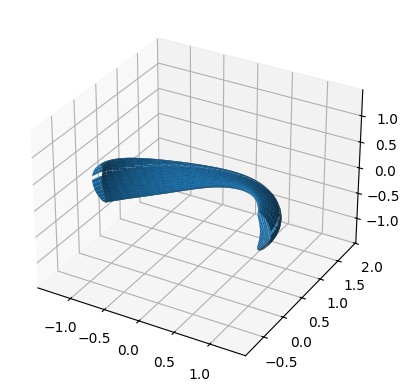

<Axes3D: >

In [29]:
qp_qss.plasma_surface.to_simsopt().plot()

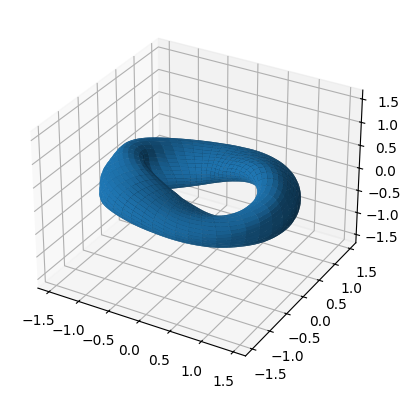

<Axes3D: >

In [30]:
qp_qss.winding_surface.to_simsopt().plot()

In [31]:
# Do a taylor test to see why the approx. failed
plasma_dof_0_list = []
phi_test_list = []
f_max_Phi_test_list = []
f_max_Phi_diff_test_list = []
cond_list = []
time_quadcoil_list = []
time_regcoil_list = []
lam_list = []
mu_list = []
c_list = []
qp_list = []
for i in jnp.linspace(-0.1, 0.1, 60):
    plasma_dof_i = np.array(qp_qss.plasma_surface.get_dofs()).copy()
    plasma_dof_i[0] *= (1 + i)
    # Run QUADCOIL first
    time1 = time.time()
    out_dict_i, qp_i, dofs_i, status_i = quadcoil(
        plasma_dofs=plasma_dof_i,
        nfp=qp_qss.nfp,
        plasma_coil_distance=-separation,
        stellsym=qp_qss.stellsym,
        plasma_mpol=qp_qss.plasma_surface.mpol,
        plasma_ntor=qp_qss.plasma_surface.ntor,
        net_poloidal_current_amperes=qp_qss.net_poloidal_current_amperes,
        metric_name=('f_max_Phi',),
        # verbose=1,
        **quadcoil_kwargs,
    )
    qp_list.append(qp_i)
    print('f_B!!!!!!!', f_B(qp_i, dofs_i))
    block_until_ready(dofs_i)
    block_until_ready(out_dict_i)
    block_until_ready(qp_i)
    time2 = time.time()
    time_quadcoil_list.append(time2-time1)
    print('time:', time2-time1)
    # REGCOIL ---------------------------------------------------
    plasma_dof_0_list.append(plasma_dof_i[0])
    phi_test_list.append(dofs_i)
    f_max_Phi_test_list.append(out_dict_i['f_max_Phi']['value'])
    f_max_Phi_diff_test_list.append(out_dict_i['f_max_Phi']['grad']['df_dplasma_dofs'][0])
    lam_list.append(status_i['inner_fin_lam'])
    mu_list.append(status_i['inner_fin_mu'])
    c_list.append(status_i['inner_fin_c'])
print('QUADCOIL avg time:', np.average(time_quadcoil_list), '(s)')
print('QUADCOIL max time:', np.max(time_quadcoil_list), '(s)')

f_B!!!!!!! 9.91917751250865e-05
time: 31.821146488189697
f_B!!!!!!! 9.916328795683046e-05
time: 8.655074834823608
f_B!!!!!!! 9.916697627127262e-05
time: 8.745163440704346
f_B!!!!!!! 9.916423790017967e-05
time: 9.255692958831787
f_B!!!!!!! 9.916891105259657e-05
time: 8.493555545806885
f_B!!!!!!! 9.916366487544967e-05
time: 8.246954202651978
f_B!!!!!!! 9.916893544637728e-05
time: 9.73501706123352
f_B!!!!!!! 9.916820296676455e-05
time: 8.81054139137268
f_B!!!!!!! 9.916577974405043e-05
time: 7.722105264663696
f_B!!!!!!! 9.917138481110002e-05
time: 8.696955919265747
f_B!!!!!!! 9.919075832230285e-05
time: 8.553797006607056
f_B!!!!!!! 9.914403183857831e-05
time: 8.633161067962646
f_B!!!!!!! 9.916907096345608e-05
time: 8.080228328704834
f_B!!!!!!! 9.91707288954068e-05
time: 8.862126111984253
f_B!!!!!!! 9.916537685953422e-05
time: 8.014079093933105
f_B!!!!!!! 9.916779463052647e-05
time: 8.913995265960693
f_B!!!!!!! 9.916749880146996e-05
time: 8.966498136520386
f_B!!!!!!! 9.917022306729542e-05
t

In [32]:
time1 = time.time()
out_dict_i, qp_i, dofs_i, status_i = quadcoil(
    plasma_dofs=plasma_dof_i,
    nfp=qp_qss.nfp,
    plasma_coil_distance=-separation,
    stellsym=qp_qss.stellsym,
    plasma_mpol=qp_qss.plasma_surface.mpol,
    plasma_ntor=qp_qss.plasma_surface.ntor,
    net_poloidal_current_amperes=qp_qss.net_poloidal_current_amperes,
    metric_name=('f_max_Phi',),
    # verbose=3,
    **quadcoil_kwargs,
)
qp_list.append(qp_i)
print('f_B!!!!!!!', f_B(qp_i, dofs_i))
block_until_ready(dofs_i)
block_until_ready(out_dict_i)
block_until_ready(qp_i)
time2 = time.time()
time_quadcoil_list.append(time2-time1)
print('time:', time2-time1)

f_B!!!!!!! 9.91822954226869e-05
time: 7.843100309371948


In [33]:
status_i

{'inner_fin_c': Array(256., dtype=float64, weak_type=True),
 'inner_fin_dl': Array(0.70820411, dtype=float64),
 'inner_fin_du': Array(8.52897087e-06, dtype=float64),
 'inner_fin_dx_scaled': Array(8.52897087e-06, dtype=float64),
 'inner_fin_f': Array(0.70806211, dtype=float64),
 'inner_fin_g': Array([-7.08062105e-01, -6.73917219e-01, -6.40684636e-01, ...,
        -1.64430187e-05, -9.49227335e-01,  1.66178367e-04], dtype=float64),
 'inner_fin_grad_l_aug': Array(0.2822761, dtype=float64),
 'inner_fin_h': Array([], shape=(0,), dtype=float64),
 'inner_fin_l_aug': Array(0.70820411, dtype=float64),
 'inner_fin_lam': Array([], shape=(0,), dtype=float64),
 'inner_fin_mu': Array([0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.1186109], dtype=float64),
 'inner_fin_niter': Array(1, dtype=int32),
 'inner_fin_x': Array([ 3.27032842e-01,  1.12838371e-02, -1.09387657e-02,  2.15797488e-04,
        -3.16713448e-03, -6.84845434e-03, -3.71433513e-03, -4.40207408e-03,
        -2.3387

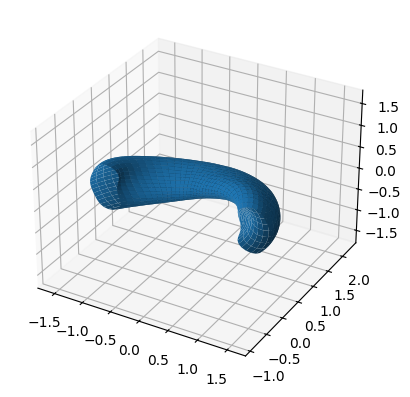

<Axes3D: >

In [34]:
qp_i.eval_surface.to_simsopt().plot()

In [35]:
breaking_params = {
    'plasma_dofs': plasma_dof_i,
    'nfp': qp_qss.nfp,
    'plasma_coil_distance': separation,
    'stellsym': qp_qss.stellsym,
    'plasma_mpol': qp_qss.plasma_surface.mpol,
    'plasma_ntor': qp_qss.plasma_surface.ntor,
    'net_poloidal_current_amperes': qp_qss.net_poloidal_current_amperes,
    'metric_name': ('f_max_Phi',),
    **quadcoil_kwargs
}
jnp.save('breaking_params', breaking_params)

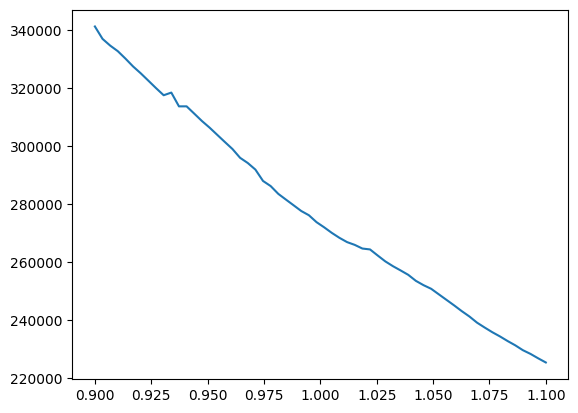

In [36]:
plt.plot(plasma_dof_0_list, f_max_Phi_test_list)

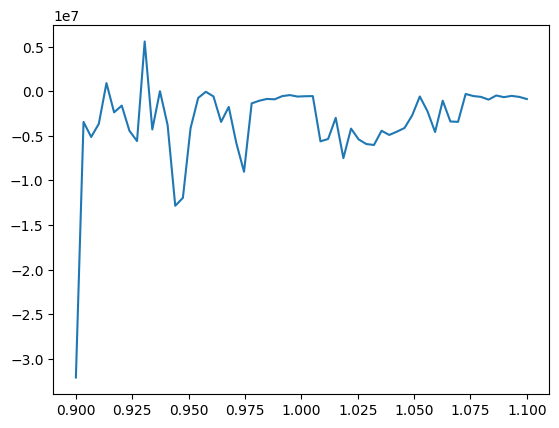

In [37]:
plt.plot(plasma_dof_0_list, f_max_Phi_diff_test_list)